In [1]:
#######################
### L03 - Exercises ###
#######################

# importing libraries and setting up nice plots

import random
import numpy                    as     np
import matplotlib.pyplot        as     plt
import matplotlib.patches       as     patches
import matplotlib.ticker		as     tck
import matplotlib.colors		as     colors
from   matplotlib				import rc
from   matplotlib.gridspec		import GridSpec
from   scipy.stats              import norm, poisson
from   sys                      import stdout


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif" : ["Times New Roman"],
	"font.size"  : 8,
    "figure.dpi" : 300
    })
plt.rc('text.latex', preamble=r'\usepackage{amssymb}')



In [2]:
#################################################
### L03 - Exercise 1: Monte Carlo integration ###
#################################################

# Lecture 03 - Exercise 01-1: Monte Carlo Integral - Convergence & Error

Using Monte Carlo Integration, verify that:

$$
    I = 
    \int_0^\infty 
    \, \textup{d}x 
    \; x^3 \exp\!\!\bigg( \!\!
        -\frac{1}{2} \frac{x^2}{\sigma^2}
    \bigg)
    = 2 \sigma^4
$$

Our goal is to write the integral as:

$$
    I = \int_0^\infty 
    \, \textup{d}x 
    \; f(x) \, \textup{pdf}(x)
$$

We recognise something similar to a zero-mean Normal distribution $\mathcal{N}(\mu = 0,\sigma)$ in the exponential factor. However, the integration domain is $(0,+\infty)$, so we must take as $\textup{pdf}(x)$ a truncated Normal distribution only for $x \geq 0$. Note that the area of such a truncated Normal is only $\frac{1}{2}$, so the pdf must be re-normalised:


$$
\textup{pdf}(x) 
= \begin{cases}
    2\,\dfrac{1}{\sigma \sqrt{2\pi}} 
  \exp\!\!\bigg( \!\!
        -\dfrac{1}{2} \dfrac{x^2}{\sigma^2}
  \bigg)
  & \textup{ if } x \geq 0
  \\
  0 & \textup{ if } x < 0
\end{cases} 
$$ 

$$
% \mathcal{N}(\mu = 0,\sigma)
% = \frac{1}{\sigma \sqrt{2\pi}} 
%   \exp\!\!\bigg( \!\!
%         -\frac{1}{2} \frac{x^2}{\sigma^2}
%   \bigg)
$$

dividing the integrand by this $\textup{pdf}(x) $, the function $f(x)$ becomes:

$$
f(x) = \sigma \sqrt{\dfrac{\pi}{2}} \, x^3
$$

With Monte Carlo integration we then define the following unbiased estimator for $I$:

$$
    \bar{I} =
    \frac{ 1 }{N} \sum_{i\,=\,1}^N f(x_i)
    = \sqrt{\frac{\pi}{2}}
    \frac{ \sigma }{N} \,\sum_{i\,=\,1}^N x_i^3 
    \quad \textup{with } x_i \textup{ drawn from } % \quad 
    \textup{pdf}(x)
    % \mathcal{N}(\mu = 0,\sigma)
$$

As this is also the definition of sample arithmetic mean, we can assign an error to this estimator using the (sample) standard deviation of the mean:

$$
    \sigma_{\bar{I}}
    = \sqrt{ \frac{1}{N} } \, s
    = \sqrt{ \frac{1}{N} } \, \sqrt{ 
        \frac{ 1 }{N-1} \sum_{i\,=\,1}^N \big( f(x_i) - \bar{I} \big)^2
    }
   \quad \textup{with } x_i \textup{ drawn from } % \quad 
    \textup{pdf}(x)
    % \mathcal{N}(\mu = 0,\sigma)
    \quad \textup{that decreases as } N^{-1/2} \textup{ for large } N

$$

Where the only non-trivial consideration is that the sum grows as $N$, and then we have two factors $N^{-1/2}$ so that finally $\sigma_{\bar{I}} \propto N^{-2/2+1/2}=N^{-1/2}$

Note also that the uncertainty on $ \sigma_{\bar{I}} $ is:

$$
\sigma_{\sigma_{\bar{I}}} = \sigma_{\bar{I}} \, \sqrt{ \frac{1}{2(N-1)} }  
% = \sqrt{ \frac{1}{N} } \,\sqrt{ \frac{1}{2(N-1)} } \, \sqrt{ 
%        \frac{ 1 }{N-1} \sum_{i\,=\,1}^N \big( f(x_i) - \bar{I} \big)^2
%    }
%\quad \textup{with } x_i \textup{ drawn from } % \quad 
%    \textup{pdf}(x)
\quad \textup{that decreases as } N^{-1} \textup{ for large } N
$$

Then, we can compare $ I $ with $ \bar{I} \pm \sigma_{\bar{I}}$

In [3]:
# let us take different orders of magnitude for N:

N = [ int(1e4), int(1e5), int(1e6), int(1e7), int(1e8) ]

# above, we have rewritten the integrand as f * pdf

# use an intermediate pdf, a Gaussian distr centered in 0 with non0 sigma
sigma = 1
mean  = 0
distr_gauss = norm(mean,sigma)

# extract a sample x of size N from the Gaussian distr
# note: the integral domain is (0, +infty)
#       the Gaussian distr domain is (-infty, +infty)
#       the Gaussian distr is symmetric
# then let's take the absolute value of x sampled from the usual Gaussian
# remember to correct for the wrong normalisation
# evaluate the function f on the sample x, then approx mean(f)


I_tru = 2 * sigma**4

print("Analytic sol. of the integral  = {:.6f}".format(I_tru))

I_avg = np.zeros(len(N))
I_std = np.zeros(len(N))
I_distr = [] 
I_q50 = np.zeros(len(N))
I_q84 = np.zeros(len(N))
I_q16 = np.zeros(len(N))

# for each value of N run a Monte-Carlo estimate of the integral:
for j, n in enumerate(N):
    # extract n numbers x_i with pdf defined above, interval = (-\infty,+\infty)
    x = np.array( distr_gauss.rvs(n) )   
    # take their absolute values |x_i| so that interval = positive real numbers
    x = np.abs(x)   
    # for each value x_i compute f(x_i)                     
    f = sigma * np.sqrt(np.pi/2) * x**3  
    I_distr.append(f)
    # the arithmetic mean of f(x_i) is the Monte-Carlo(n) estimator of the true integral
    m = np.mean(f)
    I_avg[j] = m
    # as error on this estimate we can use the (sample) standard deviation of the mean
    e = np.std(f, ddof=1) / np.sqrt(n)
    I_std[j] = e
    # alternatively, let us compute the 16% & 84% quantiles and the median (50% quantile)
    q16, q50, q84 = np.quantile(f, [0.16, 0.50, 0.84])
    I_q16[j] = q16
    I_q50[j] = q50
    I_q84[j] = q84
    # print results
    print(
        "N = {:.0e} Monte Carlo integral = {:.6f} +- {:.6f}   ;   (16%, 50%, 84%) quantiles = ({:.6f},{:.6f},{:.6f})"
        .format(float(n), m, e, q16, q50, q84)
        )
    

'''
fig , ax = plt.subplots(len(N),1,figsize=(5,15))

color_array = ['red','darkorange','gold','lightgreen','lightskyblue','navy','darkviolet']
bins = np.logspace(start=-2,stop=3,num=100) 
for j, n in enumerate(N):
    ax[j].hist( I_distr[j][:], bins=bins, density=True, label='$N = $ {:.0e}'.format(n), color=color_array[j])
    print()

v = np.linspace(start=0,  stop=10, num=1000)
u = v**3 * np.exp(-0.5 * v**2 / sigma**2)

for j, n in enumerate(N):
    ax[j].set_xlim(1e-2,1e1)
    ax[j].set_xscale('log')
    # ax[j].plot(v,u, label='ciao', color='black',ls='-')
    # ax[j].vlines(1, ymin=0, ymax=np.max(u), color='black', label='', ls='-.')
    # ax[j].vlines(1, ymin=0, ymax=np.max(u), color='black', label='', ls=':' )
    # ax[j].vlines(1, ymin=0, ymax=np.max(u), color='black', label='', ls='--')
    # ax[j].vlines(1, ymin=0, ymax=np.max(u), color='black', label='', ls=':' )
    # ax[j].vlines(1, ymin=0, ymax=np.max(u), color='black', label='', ls='--')

    ax[j].legend(frameon=True, framealpha=1, fancybox=False, edgecolor='black', loc=1, fontsize=6)

# save figure
fig.tight_layout()
fig.savefig('./L03_images/L03_Monte-Carlo__qualcosa.pdf', bbox_inches='tight')
'''



Analytic sol. of the integral  = 2.000000
N = 1e+04 Monte Carlo integral = 2.028036 +- 0.046468   ;   (16%, 50%, 84%) quantiles = (0.010824,0.386810,3.472186)
N = 1e+05 Monte Carlo integral = 1.996029 +- 0.013819   ;   (16%, 50%, 84%) quantiles = (0.010388,0.388575,3.483373)
N = 1e+06 Monte Carlo integral = 2.002134 +- 0.004412   ;   (16%, 50%, 84%) quantiles = (0.010394,0.386703,3.480133)
N = 1e+07 Monte Carlo integral = 2.003010 +- 0.001400   ;   (16%, 50%, 84%) quantiles = (0.010331,0.385350,3.485685)
N = 1e+08 Monte Carlo integral = 2.000160 +- 0.000442   ;   (16%, 50%, 84%) quantiles = (0.010316,0.384550,3.477118)


"\nfig , ax = plt.subplots(len(N),1,figsize=(5,15))\n\ncolor_array = ['red','darkorange','gold','lightgreen','lightskyblue','navy','darkviolet']\nbins = np.logspace(start=-2,stop=3,num=100) \nfor j, n in enumerate(N):\n    ax[j].hist( I_distr[j][:], bins=bins, density=True, label='$N = $ {:.0e}'.format(n), color=color_array[j])\n    print()\n\nv = np.linspace(start=0,  stop=10, num=1000)\nu = v**3 * np.exp(-0.5 * v**2 / sigma**2)\n\n\nfor j, n in enumerate(N):\n    ax[j].set_xlim(1e-2,1e1)\n    ax[j].set_xscale('log')\n    # ax[j].plot(v,u, label='ciao', color='black',ls='-')\n    # ax[j].vlines(1, ymin=0, ymax=np.max(u), color='black', label='', ls='-.')\n    # ax[j].vlines(1, ymin=0, ymax=np.max(u), color='black', label='', ls=':' )\n    # ax[j].vlines(1, ymin=0, ymax=np.max(u), color='black', label='', ls='--')\n    # ax[j].vlines(1, ymin=0, ymax=np.max(u), color='black', label='', ls=':' )\n    # ax[j].vlines(1, ymin=0, ymax=np.max(u), color='black', label='', ls='--')\n\n    ax[j]

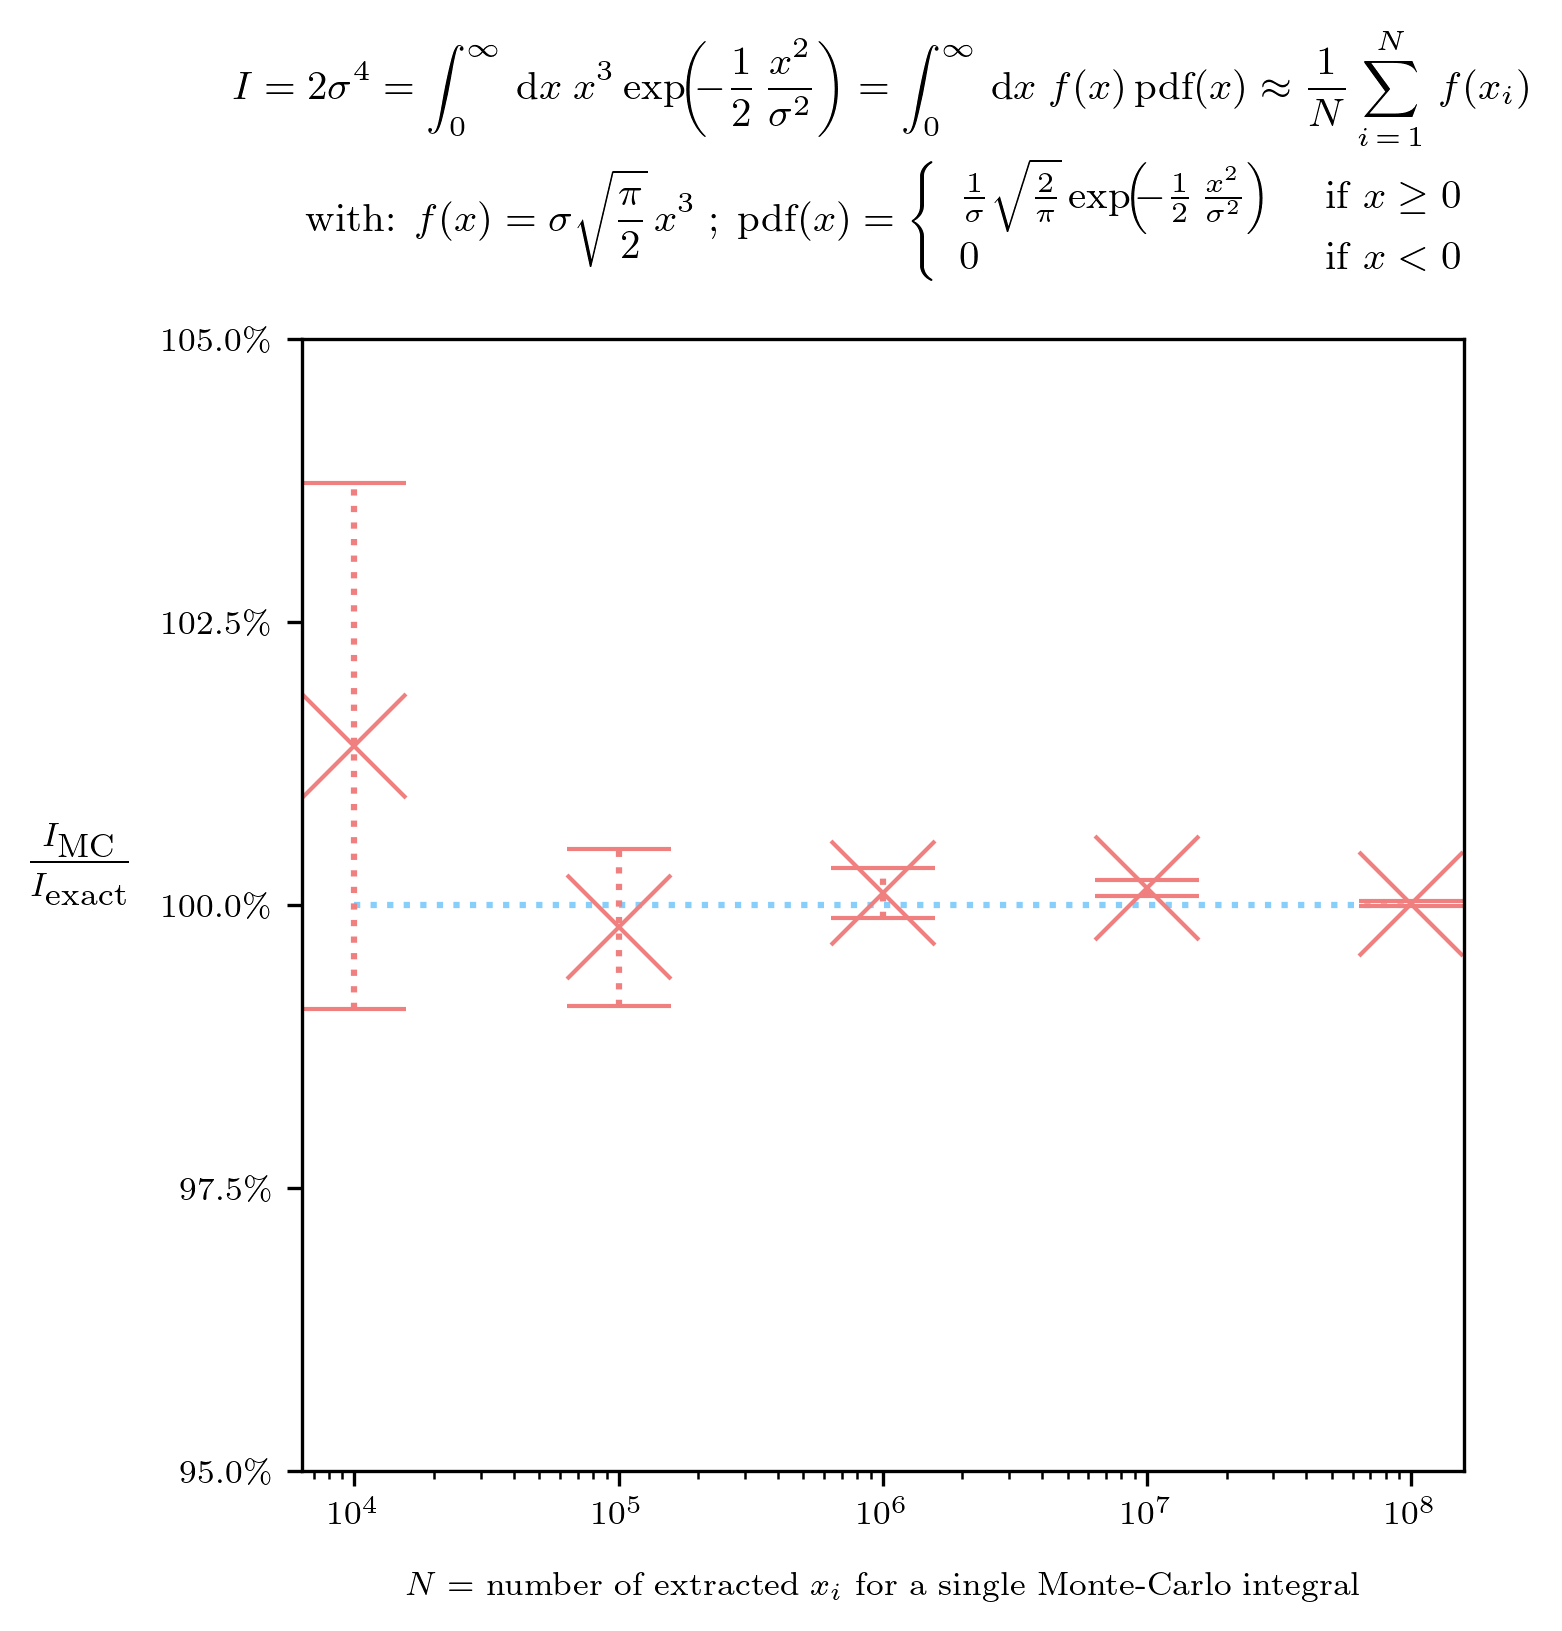

In [4]:
# let us plot the Monte Carlo estimates for the integral

N = [ int(1e4), int(1e5), int(1e6), int(1e7), int(1e8) ]

fig , ax = plt.subplots(1,1, figsize=(5,5))

# just a LaTeX title with the recap of what we did
latex_1 = (
    r"$$" 
    + r" I = 2 \sigma^4 "
    + r" = \int_0^\infty \,\textup{d}x \; x^3 \exp\!\! \left( \!\! -\frac{1}{2} \, \frac{x^2}{\sigma^2} \right)"
    + r" = \int_0^\infty \,\textup{d}x \; f(x) \, \textup{pdf}(x) "
    + r" \approx \frac{1}{N} \sum_{i\,=\,1}^N \, f(x_i)"
    + r"$$"
    + "\n" 
    + r"$$"
    + r"\textup{with: }"
    + r" f(x) = \sigma \sqrt{ \frac{\pi}{2} } \, x^3 "
    + r" \; ; \; "
    + r" \textup{pdf}(x) = "
    + r" \left\{ \begin{array}{ll} "
    + r" \frac{1}{\sigma} \sqrt{ \frac{2}{\pi} } \exp\!\!\left( \!\! -\frac{1}{2} \, \frac{x^2}{\sigma^2} \right) "
    + r" & \textup{ if } x \geq 0 "
    + r" \\ 0 "
    + r" & \textup{ if } x < 0 "
    + r" \end{array} \right." 
    + r"$$"
    +"\n"
)
ax.set_title(latex_1)

# for an easy comparison, just normalize the monte carlo results and their errors 
# to the true value of the integral

i_avg = I_avg / I_tru
i_std = I_std / I_tru

# the normalizded true value is 100%
ax.hlines(1, xmin=1e4, xmax=1e8, ls=':', color='lightskyblue')

# plot the normalized monte carlo results with error bars
ax.plot(N, i_avg,       ls='', marker='x', ms=25, color='lightcoral')
ax.plot(N, i_avg+i_std, ls='', marker='_', ms=25, color='lightcoral')
ax.plot(N, i_avg-i_std, ls='', marker='_', ms=25, color='lightcoral')
ax.vlines(N, ymin=i_avg-i_std, ymax=i_avg+i_std, ls=':', color='lightcoral')

# our variations are hopefully smaller than 5%, set plot limits
ax.set_ylim(0.95,1.05)
ax.yaxis.set_major_locator(tck.MultipleLocator(0.025))
ax.yaxis.set_major_formatter(tck.PercentFormatter(xmax=1.0, decimals=1))
ax.set_xscale('log')

# axis labels
ax.set_xlabel('$N=$ number of extracted $x_i$ for a single Monte-Carlo integral', labelpad=10)
ax.set_ylabel(r'$$ \frac{ I_{\textup{MC}} }{ I_{\textup{exact}} } $$', rotation='horizontal', labelpad=20)

# save figure
fig.savefig('./L03_images/L03_Monte-Carlo.pdf', bbox_inches='tight')



The plot above shows that the the Monte-Carlo integral converges to the real value. Nice.

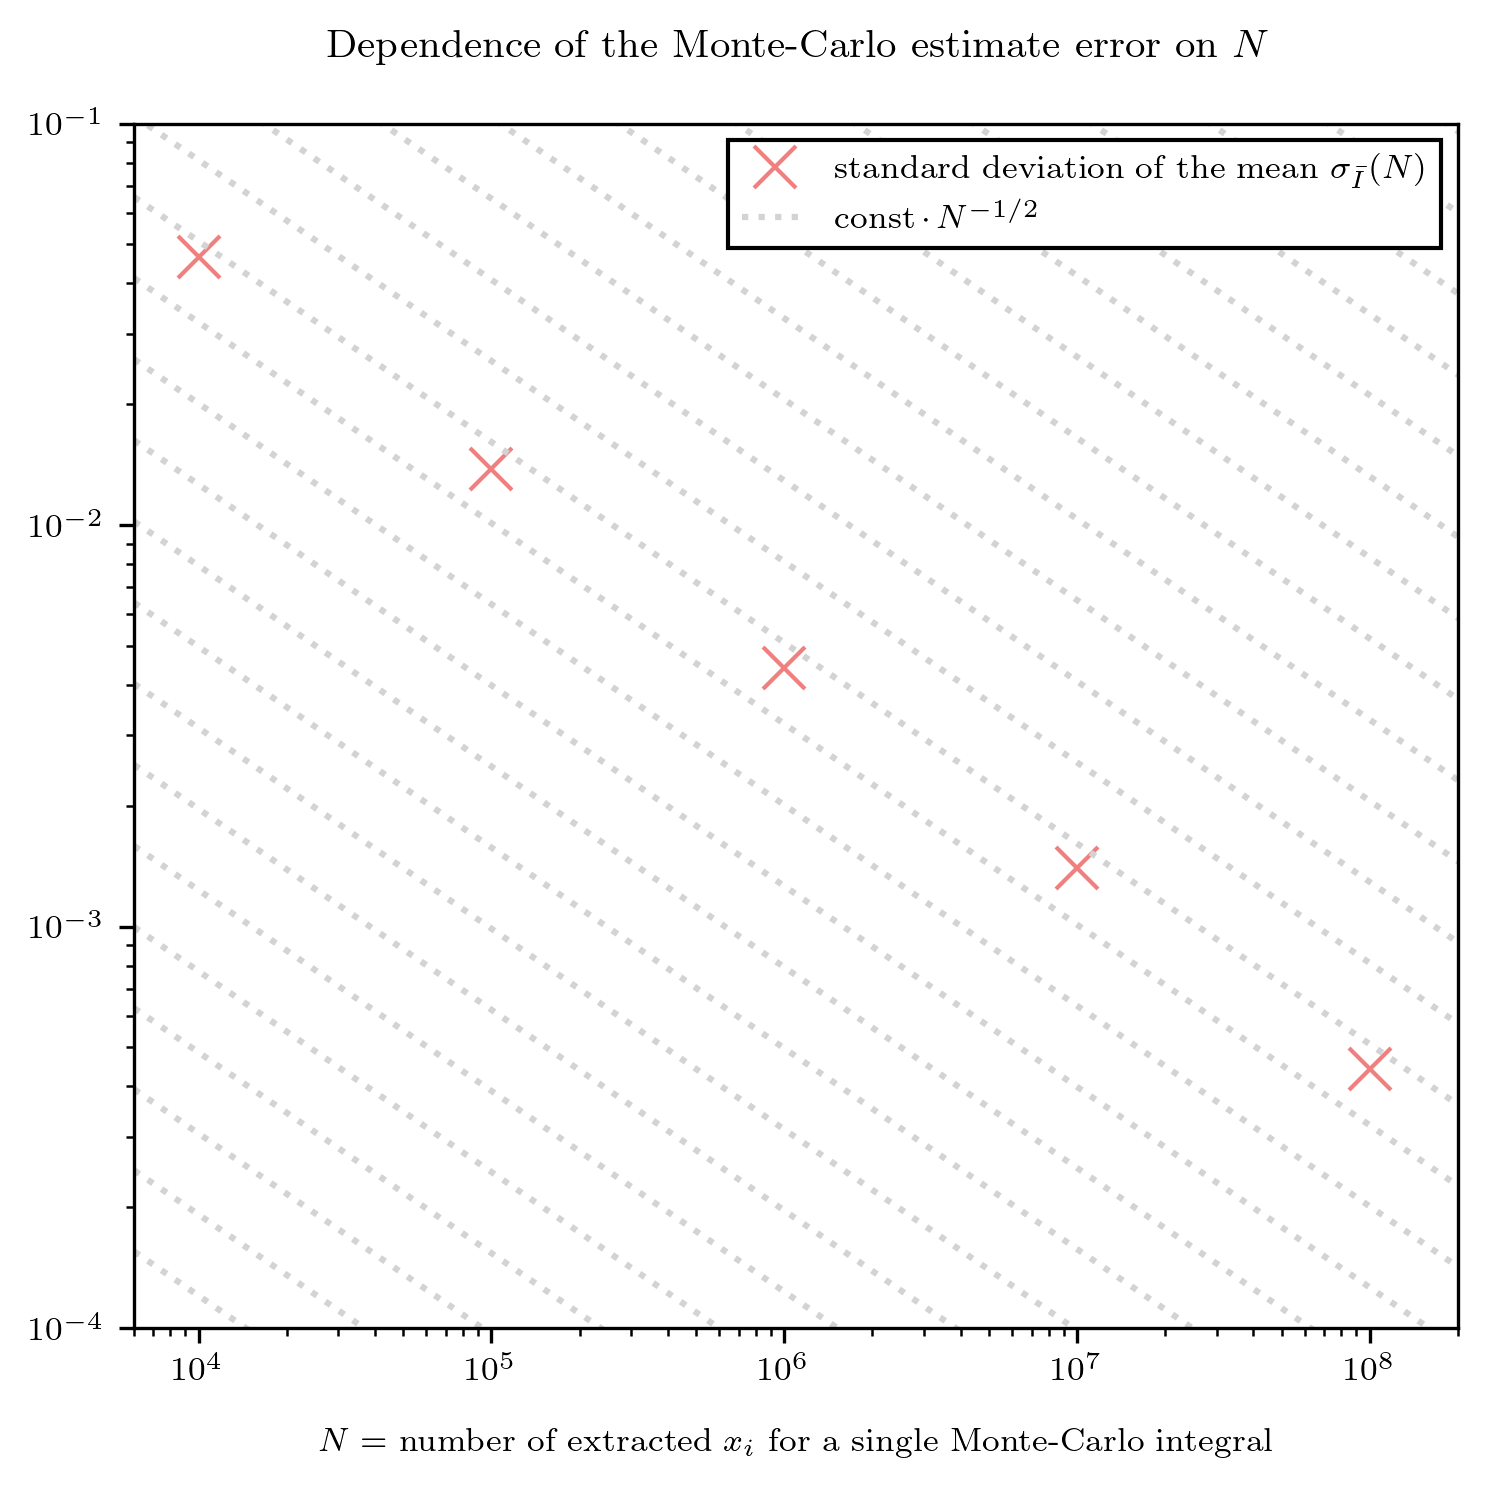

In [5]:
# To study (qualitatively) how good the Monte Carlo approximation is,
# let us plot the dependence of its uncertainty with N, as we as expressed above in formulae

N = [ int(1e4), int(1e5), int(1e6), int(1e7), int(1e8) ]

fig , ax = plt.subplots(1,1, figsize=(5,5))

ax.set_title('Dependence of the Monte-Carlo estimate error on $N$'+'\n')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(6e3,2e8)
ax.set_ylim(1e-4,1e-1)
ax.set_xlabel('$N=$ number of extracted $x_i$ for a single Monte-Carlo integral', labelpad=10)

ax.plot(N, I_std, ls='', marker='x', ms=10, color='lightcoral', label=r'standard deviation of the mean $\sigma_{\bar{I}}(N)$')
# ax.plot(N,I_std+I_sst, ls='', marker='_', ms=25, color='lightcoral')
# ax.plot(N,I_std-I_sst, ls='', marker='_', ms=25, color='lightcoral')
# ax.vlines(N, ymin=I_std-I_sst, ymax=I_std+I_sst, ls='-', color='lightcoral')
# labelin_1 = r'$$ \sigma_{\bar{I}}(N) = \frac{s(N)}{\sqrt{N_{\textup{mc}}}} = \frac{1}{\sqrt{N_{\textup{mc}}}}\frac{1}{N-1}\sum_{i=1}^N (I_i-\bar{I})^2 $$' #\, \sqrt{N_{\textup{mc}}}

# plot some lines for the relation sigma_bar{I} \approx const * N^{-1/2} (in a loglog plot, these are straight lines)
xn = np.logspace(3.5,8.5,1000)
beta = np.linspace(-10,10.,100)
for k, b in enumerate(beta):
    fn = xn**(-1/2) * 10**b
    if k > 0:
        ax.plot(xn, fn, color='lightgrey', ls=':')
    else:
        ax.plot(xn, fn, color='lightgrey', ls=':', label=r'const$ \, \cdot \, N^{-1/2}$') 

ax.legend(frameon=True, framealpha=1, fancybox=False, edgecolor='black', loc=1)

# save figure
fig.tight_layout()
fig.savefig('./L03_images/L03_Monte-Carlo__std.pdf', bbox_inches='tight')




We have qualitatively verified the dependence of $ \sigma_{\bar{I}} $ on $N$ we made explicit in the formulae above:
$$ 
    \log_{10}( \sigma_{\bar{I}} ) 
    \sim 
    \alpha \cdot log_{10}( N ) + \beta
    \iff
    \sigma_{\bar{I}} \sim N^\alpha \cdot 10^\beta 
    \quad ; \quad \textup{ with } \alpha \sim -\frac{1}{2}
$$



# Lecture 03 - Exercise 01-2: Monte Carlo Integral - Multiple iterations

Let us now evaluate the Monte Carlo integral, for a given $N$, a number of times $M$. Then, let us investigate how the $M$ results $\bar{I}_{N,i}$ are distributed.

In [10]:
# since we follow the same procedure but iterate M times, we don't comment each line as much
# NOTE: this cell takes a while to run:
####### around 30 mins if N_max = 1e8 & M = 200. 
####### around 3  mins if N_max = 1e7 & M = 200. 
####### around 3 hours if N_max = 1e7 & M = 1e4

N = [ int(1e4), int(1e5), int(1e6), int(1e7)] #, int(1e8) ]

M = 10000
I_avg_ji = np.zeros((len(N),M))
I_std_ji = np.zeros((len(N),M))

print("A mischievous progress bar that fills up ever slower..."+'\n')
# for each value of N run a Monte-Carlo estimate of the integral M times
for j, n in enumerate(N):
    for i in range(M):
        x = np.array( distr_gauss.rvs(n) )   
        x = np.abs(x)   
        f = sigma * np.sqrt(np.pi/2) * x**3  
        m = np.mean(f)
        I_avg_ji[j,i] = m
        e = np.std(f, ddof=1) / np.sqrt(n)
        I_std_ji[j,i] = e
        # print progress: how many integrals we have computed... 
        # ...but integrals for larger N take longer, and this is unaccounted for
        stdout.write('\rComputed the N = {:d} M.C. Integral M = {:d} times! Total progress = {:.3f}%'.format(n,i,(j*M+i)/(len(N)*M)*100))
    print('\n'+"computed the N = {:d} M.C. Integral M = {:d} times!".format(n,M))
stdout.write('\rComputed the N = {:d} M.C. Integral M = {:d} times! Total progress = {:.3f}%'.format(n,M,100.))




A mischievious progress bar that fills up ever slower...

Computed the N = 10000 M.C. Integral M = 9999 times! Total progress = 24.997%
computed the N = 10000 M.C. Integral M = 10000 times!
Computed the N = 100000 M.C. Integral M = 9999 times! Total progress = 49.998%
computed the N = 100000 M.C. Integral M = 10000 times!
Computed the N = 1000000 M.C. Integral M = 9999 times! Total progress = 74.997%
computed the N = 1000000 M.C. Integral M = 10000 times!
Computed the N = 10000000 M.C. Integral M = 9999 times! Total progress = 99.997%
computed the N = 10000000 M.C. Integral M = 10000 times!
Computed the N = 10000000 M.C. Integral M = 10000 times! Total progress = 100.000%

83

In [33]:
# SAVE integrals to a file since the previous cell takes about 3 hours to run when N_max = 1e7 & M = 1e4

filename = "./Nmax_{:.0e}__M_{:.0e}__Integrals.txt".format(N[-1],M)

if False:
    with open(filename, 'wb') as file:
        np.save(file, len(N) )
        np.save(file, M)
        for j, n in enumerate(N):
            np.save(file, n )
            np.save(file, I_avg_ji[j,:])
            np.save(file, I_std_ji[j,:])
    print("Integrals saved to " + filename)

# this is a code snippet to check whether the file has been saved properly
if False:
    with open(filename, 'rb') as test_file:
        nn = np.load(test_file)
        mm = np.load(test_file)
        NN = np.zeros(nn)
        I_avg_test_ji = np.zeros((nn,mm))
        I_std_test_ji = np.zeros((nn,mm))
        for j in range(nn):
            NN[j] = np.load(test_file)
            I_avg_test_ji[j,:] = np.load(test_file)
            I_std_test_ji[j,:] = np.load(test_file)
    print("Test: (j,i)=(3,12)   notebook   I = {:.6f} +- {:.6f}".format(I_avg_ji[3,12]      , I_std_ji[3,12]     ))
    print("Test: (j,i)=(3,12)   testfile   I = {:.6f} +- {:.6f}".format(I_avg_test_ji[3,12] , I_std_test_ji[3,12]))
        

For each $N$, the $M$ Monte Carlo integrals $\bar{I}_{N,i}$ are obtained as the average of one sample of size $N$ ($M$ samplings for each $N$). Then, we expect to be able to apply the central limit theorem, and for each $N$ the $M$ integrals should follow Normal distributions with width proportional to the typical error of each estimate, of order $\sigma_{\bar{I}}(N)$, centered on the true (analytic) value of the integral. 

In other words, we expect (for a given $N$) to have $\bar{I}_{N,i}$ distributed according to $ \mathcal{N} \Big( \mu = \bar{I}_M(N) \approx I_{\textup{true}}, \sigma = \sigma_{ \bar{I}_M }(N) \Big)$.

In the formula we have denoted the sample standard distribution and the sample arithmetic mean of the $M$ integrals (for a given $N$) as:

$$
    \sigma_{ \bar{I}_M } (N) 
    = \sqrt{ { \displaystyle \frac{1}{M-1} } \, {\displaystyle \sum_{i=1}^M} \,\,\Big( \bar{I}_i(N) - \bar{I}_M(N) \Big)^2 } 
    \quad \textup{with} \quad
    \bar{I}_M(N) = \displaystyle \frac{1}{M} \, {\displaystyle \sum_{i=1}^M} \,\, \bar{I}_i(N) \to I_{\textup{true}}
    \quad \textup{for large } N
$$

This sample standard deviation should be comparable to the individual errors of the $M$ Monte Carlo estimates (for a given $N$), so e.g. using their arithmetic mean:

$$
    \bar{\sigma}_{\bar{I}_M}(N)
    = \frac{1}{M} \, {\displaystyle \sum_{i=1}^M} \,\, \sigma_{\bar{I}_i}(N)
$$

We should then have 

$$
    \sigma_{ \bar{I}_M } (N) \sim \bar{\sigma}_{\bar{I}_M}(N)
$$

Note that this allows us to use $\bar{I}_M$ as a new estimator for $I$ with the (new) standard deviation of the mean as error, smaller than the error on the single Monte Carlo integral by the usual factor $M^{-1/2}$

$$
I \approx \bar{I}_M(N) \pm {\displaystyle \frac{\sigma_{ \bar{I}_M } (N) }{\sqrt{M}}} 
  \sim \bar{I}_M(N) \pm {\displaystyle \frac{\bar{\sigma}_{\bar{I}_M}(N)}{\sqrt{M}}} 
$$



mean = 1.999948 ; stddev = 0.044801 ; mean = 0.044198
mean = 1.999861 ; stddev = 0.013940 ; mean = 0.013986
mean = 2.000073 ; stddev = 0.004390 ; mean = 0.004423
mean = 2.000021 ; stddev = 0.001395 ; mean = 0.001399


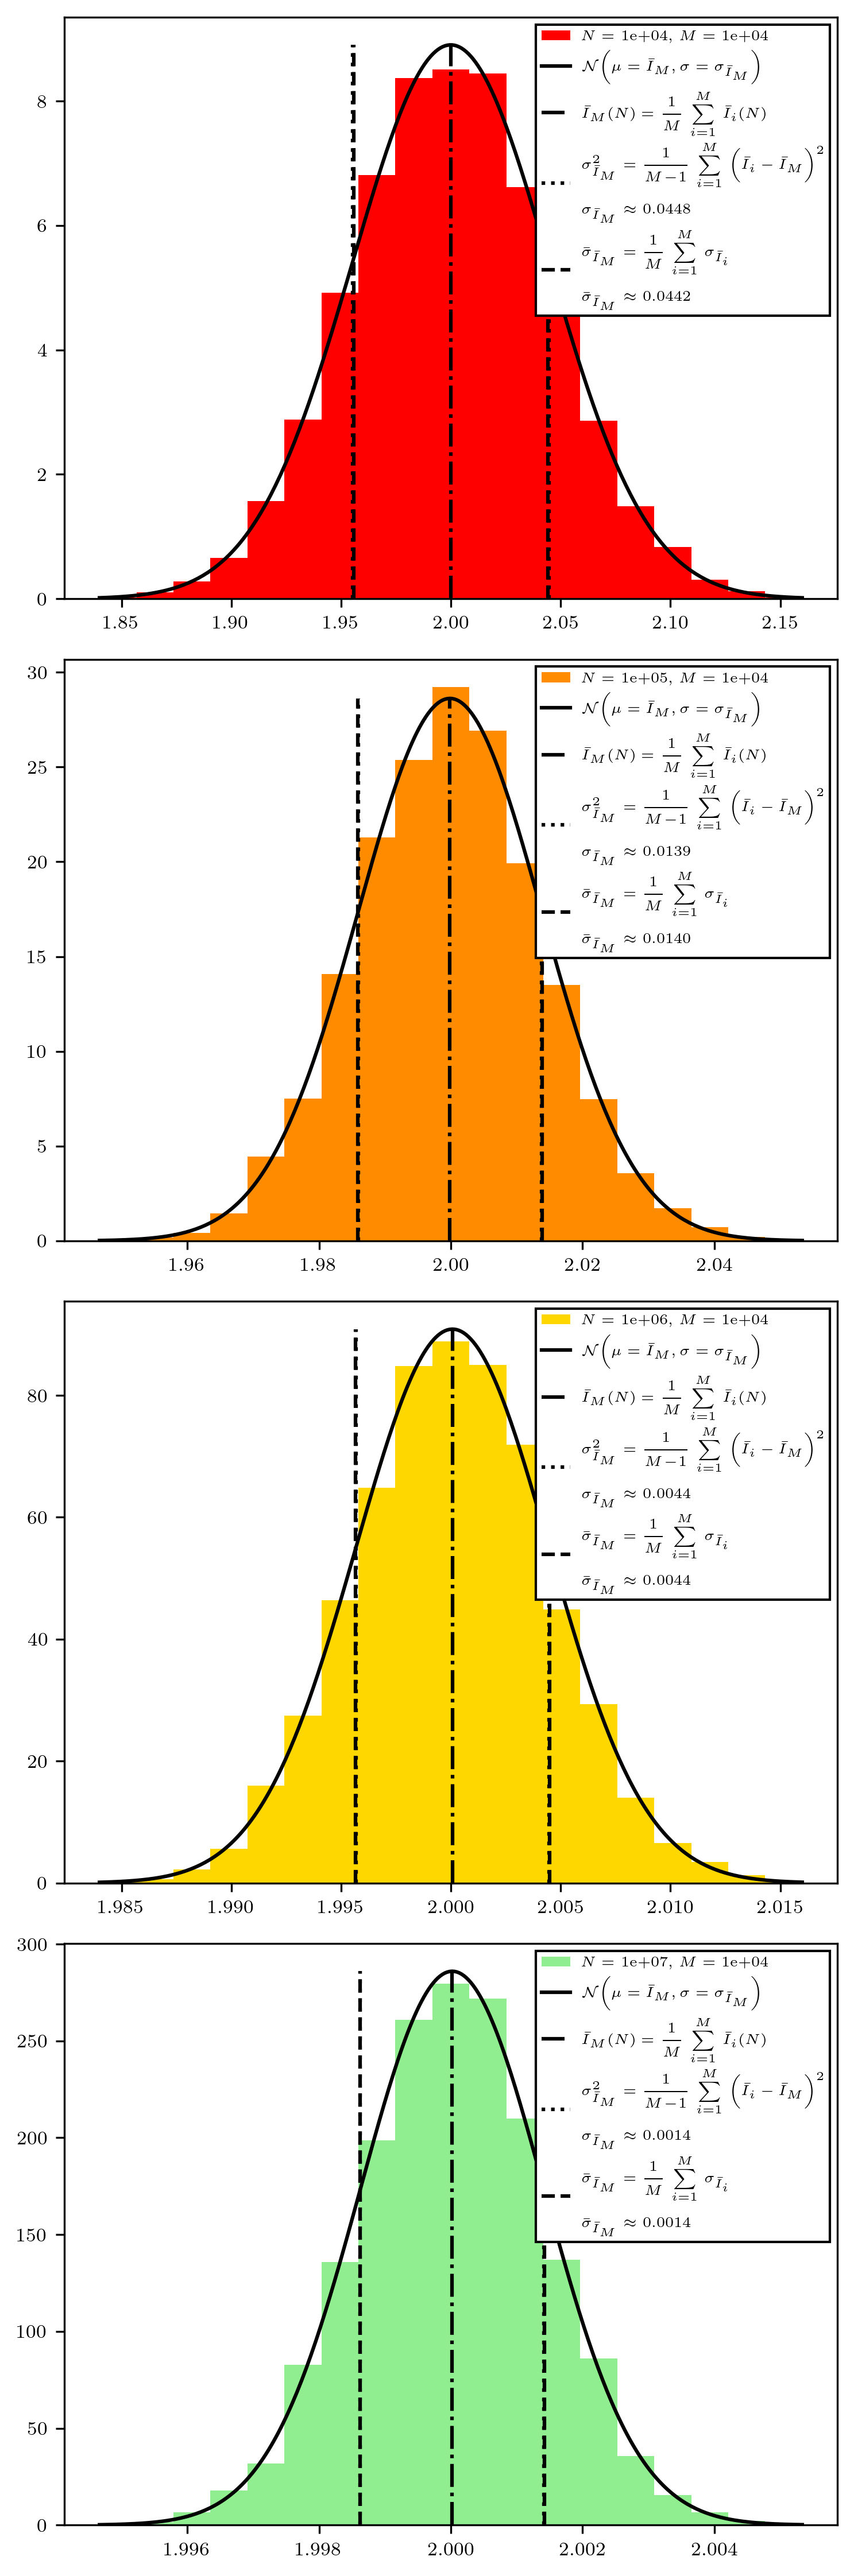

In [34]:
N = [ int(1e4), int(1e5), int(1e6), int(1e7) ] # , int(1e8) ]

fig , ax = plt.subplots(len(N),1,figsize=(5,15))

color_array = ['red','darkorange','gold','lightgreen','lightskyblue','navy','darkviolet']
bin_array   = [
    np.linspace(start=I_tru-0.08*I_tru,     stop=I_tru+0.08*I_tru    , num=20), # bins for N = 1e4
    np.linspace(start=I_tru-0.08*I_tru/3  , stop=I_tru+0.08*I_tru/3  , num=20), # bins for N = 1e5
    np.linspace(start=I_tru-0.08*I_tru/10 , stop=I_tru+0.08*I_tru/10 , num=20), # bins for N = 1e6
    np.linspace(start=I_tru-0.08*I_tru/30 , stop=I_tru+0.08*I_tru/30 , num=20), # bins for N = 1e7
    np.linspace(start=I_tru-0.08*I_tru/100, stop=I_tru+0.08*I_tru/100, num=20)  # bins for N = 1e8 if present
]

# ax.set_xlim((bin_array[0].min(),bin_array[0].max()))

# plot the M MonteCarlo integrals for each N:
for j, n in enumerate(N):
    ax[j].hist( I_avg_ji[j,:], bins=bin_array[j], density=True, label='$N = $ {:.0e}, $M = $ {:.0e}'.format(n,M), color=color_array[j])

avg_avg_j = np.zeros(len(N))
std_avg_j = np.zeros(len(N))
avg_std_j = np.zeros(len(N))
for j , n in enumerate(N):
    m = np.mean( I_avg_ji[j,:] )
    s = np.std( I_avg_ji[j,:] , ddof=1)
    a = np.mean( I_std_ji[j,:] )
    avg_avg_j[j] = m
    std_avg_j[j] = s
    avg_std_j[j] = a
    print("mean = {:.6f} ; stddev = {:.6f} ; mean = {:.6f}".format(m,s,a))

xvars = [
    np.linspace(start=I_tru-0.08*I_tru,     stop=I_tru+0.08*I_tru    , num=300), # bins for N = 1e4
    np.linspace(start=I_tru-0.08*I_tru/3  , stop=I_tru+0.08*I_tru/3  , num=300), # bins for N = 1e5
    np.linspace(start=I_tru-0.08*I_tru/10 , stop=I_tru+0.08*I_tru/10 , num=300), # bins for N = 1e6
    np.linspace(start=I_tru-0.08*I_tru/30 , stop=I_tru+0.08*I_tru/30 , num=300), # bins for N = 1e7
    np.linspace(start=I_tru-0.08*I_tru/100, stop=I_tru+0.08*I_tru/100, num=300)  # bins for N = 1e8 if present
]

for j, n in enumerate(N):
    v = xvars[j]
    M_gauss_N = norm(loc=avg_avg_j[j],scale=std_avg_j[j])
    u = M_gauss_N.pdf(v)
    
    justalabel_n = r'$\mathcal{N} \big( \mu = \bar{I}_M, \sigma = \sigma_{ \bar{I}_M } \big) $'
    justalabel_m = r'$\bar{I}_M(N) =  {\displaystyle \frac{1}{M} \, \sum_{i=1}^M} \,\,\bar{I}_i(N)$'
    justalabel_s = r'$\sigma_{ \bar{I}_M }^2 = {\displaystyle \frac{1}{M\!-\!1} \, \sum_{i=1}^M} \,\,\big( \bar{I}_i - \bar{I}_M \big)^2$' 
    justalabel_s += '\n\n' + r'$ \sigma_{ \bar{I}_M } \approx $' + ' {:.4f}'.format( std_avg_j[j] )
    justalabel_a = r'$\bar{\sigma}_{\bar{I}_M} = {\displaystyle \frac{1}{M} \, \sum_{i=1}^M} \,\, \sigma_{\bar{I}_i}$'
    justalabel_a += '\n\n' + r'$\bar{\sigma}_{ \bar{I}_M } \approx $' + ' {:.4f}'.format( avg_std_j[j] )

    ax[j].plot(v,u, label=justalabel_n, color='black',ls='-') # color_array[j]
    ax[j].vlines(avg_avg_j[j],              ymin=0, ymax=np.max(u), color='black', label=justalabel_m, ls='-.') # color=color_array[j]
    ax[j].vlines(avg_avg_j[j]+std_avg_j[j], ymin=0, ymax=np.max(u), color='black', label=justalabel_s, ls=':' ) # color=color_array[j]
    ax[j].vlines(avg_avg_j[j]+avg_std_j[j], ymin=0, ymax=np.max(u), color='black', label=justalabel_a, ls='--') # color=color_array[j]
    ax[j].vlines(avg_avg_j[j]-std_avg_j[j], ymin=0, ymax=np.max(u), color='black', label='', ls=':' ) # color=color_array[j]
    ax[j].vlines(avg_avg_j[j]-avg_std_j[j], ymin=0, ymax=np.max(u), color='black', label='', ls='--') # color=color_array[j]

    ax[j].legend(frameon=True, framealpha=1, fancybox=False, edgecolor='black', loc=1, fontsize=6)

# save figure
fig.tight_layout()
fig.savefig('./L03_images/L03_Monte-Carlo__distribs.pdf', bbox_inches='tight')



# Lecture 03 - Exercise 02 - Kicking Horses (Poisson distribution)

sample mean:                   m = 0.610
sample standard deviation:     s = 0.782
sq. root of sample mean: sqrt(m) = 0.781
If the deaths follow a Poisson distribution, we should have s similar to sqrt(m)


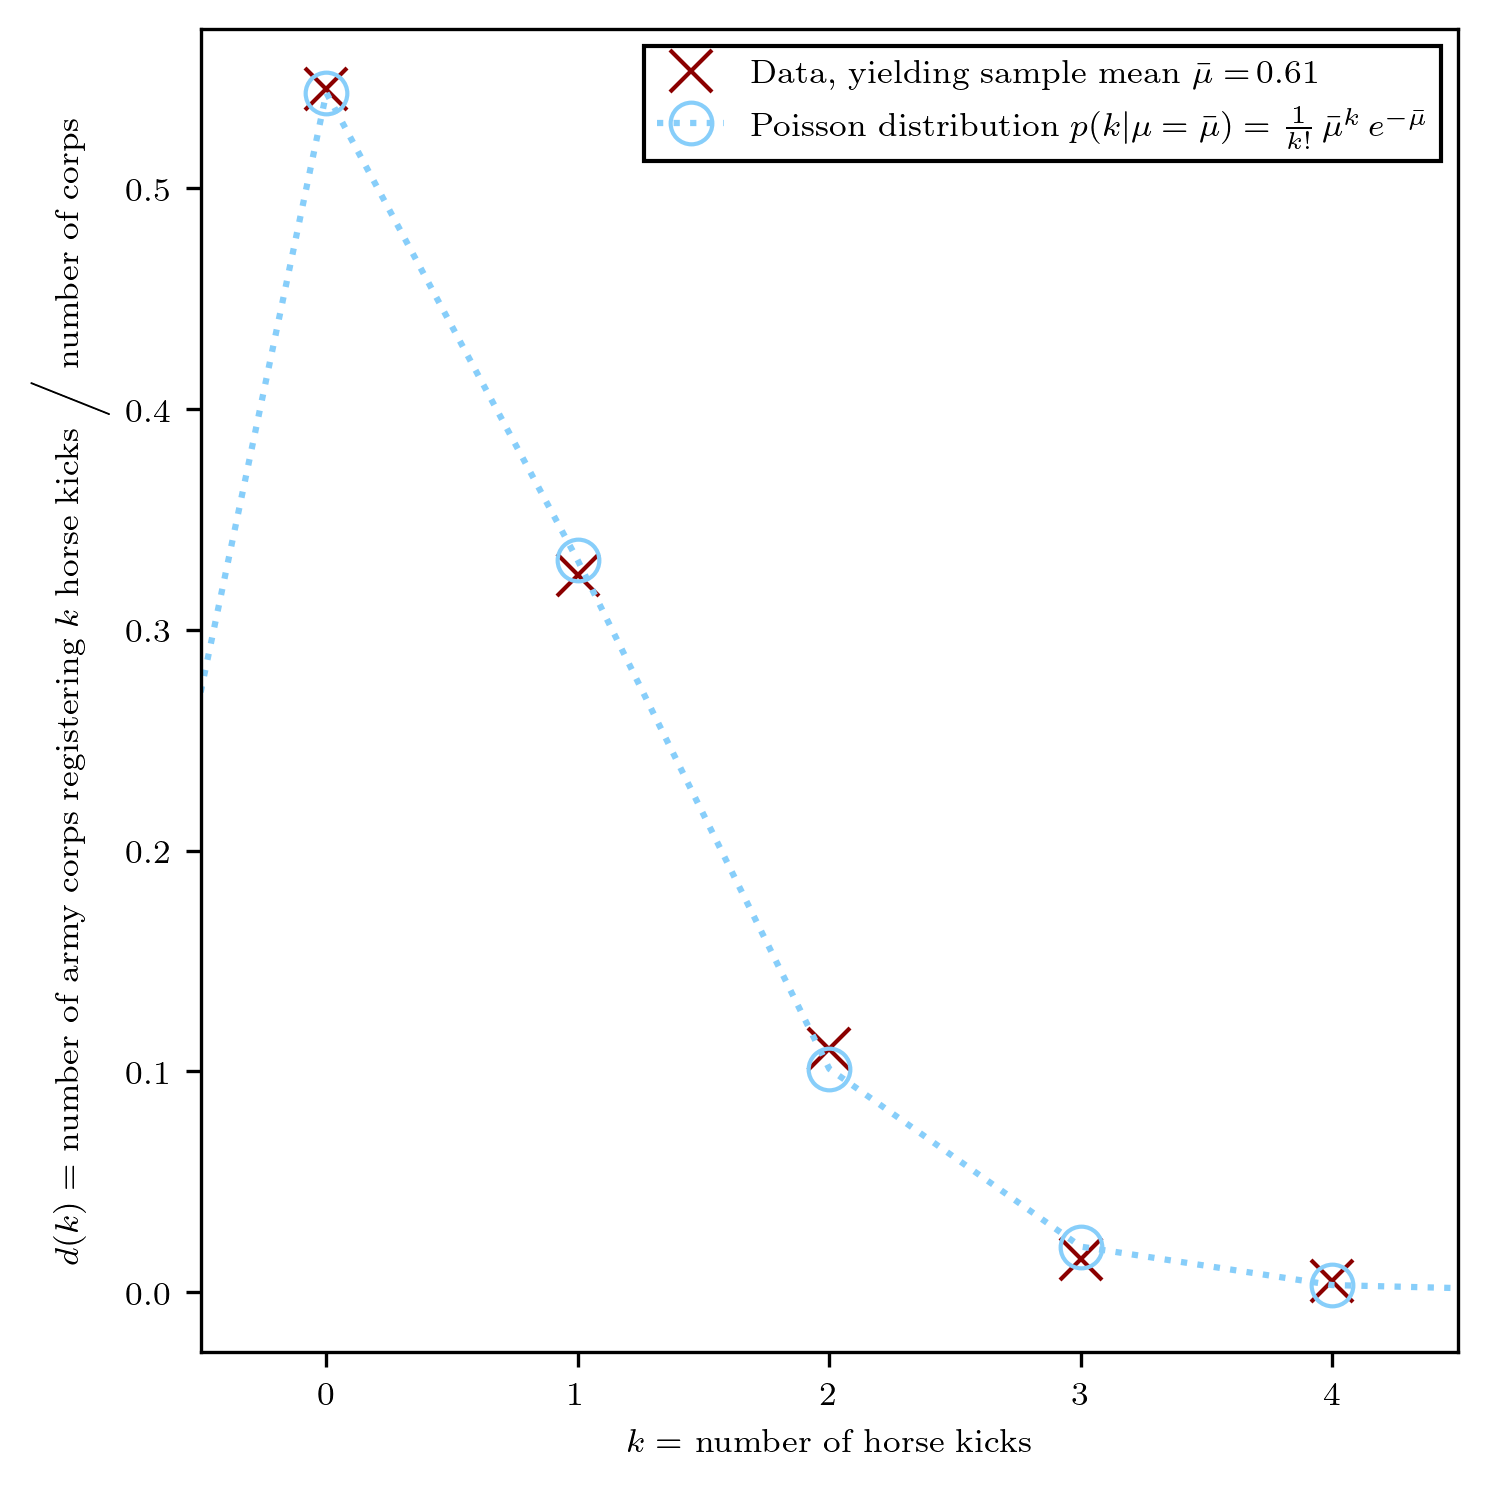

In [69]:
########################################
### L03 - Exercise 2: Kicking Horses ###
########################################


# numbers of military corpes...
c = np.array( [109, 65, 22, 3, 1] )

# ...measuring the following numbers of deaths
d = np.array( [0, 1, 2, 3, 4] )

# total number of military corpes 
t = np.sum(c)

# compute the sample mean:
m = np.sum(d * c/t)

# compute the sample standard deviation:
v = np.sum( (d-m)**2 * c/t * t/(t-1) )    # t/(t-1) is the Bessel correction
s = np.sqrt(v)

# print results
print('sample mean:                   m = {:.3f}'.format(m))
print('sample standard deviation:     s = {:.3f}'.format(s))
print('sq. root of sample mean: sqrt(m) = {:.3f}'.format(np.sqrt(m)))
print("If the deaths follow a Poisson distribution, we should have s similar to sqrt(m)")

# We use the sample mean as the estimator of the true mean of an underlying Poisson distribution 
distr_poiss = poisson(m)
x = np.arange(-1,10)
y = distr_poiss.pmf(x)

# plot the data and the rudimentary Poisson description
fig , ax = plt.subplots(1,1, figsize=(5,5))
ax.set_xlim(xmin=-0.5, xmax=4.5)
ax.set_xlabel('$k = $ number of horse kicks')
ax.set_ylabel(r'$d(k) = $ number of army corps registering $k$ horse kicks $\Big/$ number of corps')
data_label    = r'Data, yielding sample mean $ \bar{\mu} = \,$' + '{:.2f}'.format(m)
poisson_label = r'Poisson distribution $ p(k|\mu = \bar{\mu}) = \frac{1}{k!} \, \bar{\mu}^k \, e^{-\bar{\mu}} $'

# plot the experimental data: number of deaths measured by how many groups
ax.plot( d , c/t, linestyle='', marker='x', markersize=10, color='darkred', label=data_label)

# plot our poisson estimate of the underlying pdf
ax.plot(x,y, linestyle=':', color='lightskyblue',marker = 'o', markersize=10 , mfc='none', mec='lightskyblue' , label=poisson_label)

# legend and save figure
ax.legend(frameon=True, framealpha=1, fancybox=False, edgecolor='black', loc=1)
fig.tight_layout()
fig.savefig('./L03_images/L03_Horse-Kicks.pdf', bbox_inches='tight')







We find that the Poisson distribution $p(k\,|\,\mu)$ is a good approximation for $d(k)$:

$$
    p(k\,|\,\mu) = \frac{1}{k!} \, \mu^k \, e^{-\,\mu}
$$

with $\mu$ taken to be the sample mean $\bar{\mu}$:

$$
    \bar{\mu} = \frac{1}{N} \sum_{i=1}^N \, k_i \, d(k_i)
$$


